In [1]:
import sys
import os
import csv
import time
import statistics
import numpy as np
from pathlib import Path, PureWindowsPath
from numpy import dot
from numpy.linalg import norm
import networkx as nx
import networkx.algorithms.matching
from collections import Counter
from IPython.display import Image, display
from matplotlib import pyplot as plt
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [3]:
def similarityMetric(sr):
    counterA = 0
    counterB = 0
    counterC = 0
    for i in sr :
        A,B = i[0].split(',')[0], i[0].split(',')[1]
        C,D = i[2].split(',')[0], i[2].split(',')[1]
        if A==C and B==D:
            counterA +=1
        if A==C or B==D:
            counterB +=1
        if A==C or A==D or B == C or B == D:
            counterC += 1
    print("cA = %d (%f) cB= %d (%f) cC =%d (%f)"%(counterA, counterA/len(sr), counterB, counterB/len(sr), counterC, counterC/len(sr)))
    return [counterA/len(sr),counterB/len(sr),counterC/len(sr)]

In [4]:
def createDirs(fold):
    
    path = "DATASET F1/fold_" +str(fold)
    mal_path = path+ "/20%_test"
    train_path = path+ "/80%_train"
    benign_path = "DATASET F1/specimen_benign/20%_test"
    
    w_mal_path = PureWindowsPath(mal_path)
    w_train_path= PureWindowsPath(train_path)
    w_benign_path = PureWindowsPath(benign_path)
    print( mal_path+"\n"+ train_path+"\n"+ benign_path)
    print( w_mal_path, w_train_path, w_benign_path)

    filename = "default_G_tone_map"
    mapFilename = "default_unique_mapping"
    
    rootDir = [os.path.join(root, name)
             for root, dirs, files in os.walk(w_mal_path)
             for name in files
             if name.endswith(filename+".csv")]
    rootDir.sort()
    # for i in range(len(paths)):
    #     p = [os.path.join(root, name)
    #              for root, dirs, files in os.walk(paths[i]+"/"+path)
    #              for name in files
    #              if name.endswith(filename+".csv")]
    #     p.sort()
    #     rootDirs[i] = p
    # print(rootDirs[10])
    benignDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_benign_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    benignDir.sort()

    # for i in range(len(paths)):
    trainDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_train_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    trainDir.sort()
    #     trainDirs[i] = trainDir
    return [rootDir,benignDir,trainDir]

In [5]:
def createGraphs(dirs, npmode):
    rootDir = dirs[0]
    benignDir = dirs[1]
    trainDir = dirs[2]
    mal_gs = []
    mal_np_gs = []
    ben_gs = []
    train_gs = []
    train_np_gs = []
    ben_np_gs = []
    csm_vals = {}
    for i in range(len(rootDir)):
        A = np.array(getArray(rootDir[i]))
        G = nx.from_numpy_matrix(A)
        mal_gs.append(G)
        mal_np_gs.append(A)
        printProgressBar(i, len(rootDir)-1, prefix = 'malware gs')

    for i in range(len(trainDir)):
        A = np.array(getArray(trainDir[i]))
        G = nx.from_numpy_matrix(A)
        train_gs.append(G)
        train_np_gs.append(A)
        printProgressBar(i, len(trainDir)-1, prefix = 'train gs')
        
    for i in range(len(benignDir)):
        A = np.array(getArray(benignDir[i]))
        G = nx.from_numpy_matrix(A)
        ben_gs.append(G)
        ben_np_gs.append(A)
        printProgressBar(i, len(benignDir)-1, prefix = 'benign gs')
    if npmode: 
        return [mal_np_gs, ben_np_gs, train_np_gs]
    else: 
        return [mal_gs, ben_gs, train_gs]



In [6]:
def getArray (path):
    results = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile,csv.QUOTE_NONNUMERIC) # change contents to floats
        for row in reader: # each row is a list
            nums = []
            for i in row: 
                if i :
                    nums.append(int(i))
            results.append(nums)
    return results

In [7]:
def detection(ben, mal, step= 10):
    dif = ben[0]-ben[-1]
    thresh = [ben[-1]+i*dif/step for i in range(step)]
    m = np.array(sum(i > thresh for i in mal)/len(mal))
    p = np.array(sum(i > thresh for i in ben)/len(ben))
#     print(m)
    plt.plot(m)
    plt.plot(p)


In [8]:
c = createDirs(1)
print(len(c))

DATASET F1/fold_1/20%_test
DATASET F1/fold_1/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_1\20%_test DATASET F1\fold_1\80%_train DATASET F1\specimen_benign\20%_test
3


In [9]:
g = createGraphs(c, False)

malware gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
train gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
benign gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [10]:
def calculateDifference(listA, listB, dirs,isBenign):
    csm_val = []
    rootDir = dirs[0]
    benDir = dirs[1]
    trainDir = dirs[2]
    for i in range(len(listA)):
        printProgressBar(i,len(listA)-1,prefix='diff calculation:')
        val = []
        for j in range(len(listB)):
            val.append(1-distance.cosine(listA[i], listB[j]))
        if isBenign:
            csm_val.append([benDir[i].split('\\')[-3],max(val),trainDir[val.index(max(val))].split('\\')[-3]])
        else :
            csm_val.append([rootDir[i].split('\\')[-3],max(val),trainDir[val.index(max(val))].split('\\')[-3]])
    return csm_val

In [11]:
from networkx.algorithms import approximation as approx

In [12]:
e = [approx.average_clustering(g[0][i]) for i in range(len(g[0]))]

In [13]:
q =[approx.average_clustering(g[1][i]) for i in range(len(g[1]))]

(array([2., 3., 0., 0., 4., 8., 4., 7., 3., 4.]),
 array([0.138 , 0.1635, 0.189 , 0.2145, 0.24  , 0.2655, 0.291 , 0.3165,
        0.342 , 0.3675, 0.393 ]),
 <a list of 10 Patch objects>)

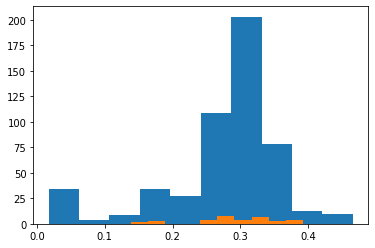

In [14]:
plt.hist(e,bins= 10)
plt.hist(q,bins=10)

In [15]:
x = [nx.degree_assortativity_coefficient(g[0][i]) for i in range(len(g[0]))]

In [16]:
f = [nx.degree_assortativity_coefficient(g[1][i]) for i in range(len(g[1]))]

(array([ 1.,  0.,  0.,  0.,  3.,  1.,  2., 15., 10.,  3.]),
 array([-0.70123023, -0.63259626, -0.56396229, -0.49532832, -0.42669435,
        -0.35806037, -0.2894264 , -0.22079243, -0.15215846, -0.08352449,
        -0.01489052]),
 <a list of 10 Patch objects>)

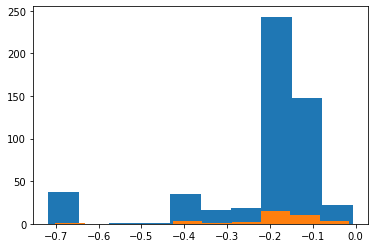

In [17]:
plt.hist(x,bins= 10)
plt.hist(f,bins=10)

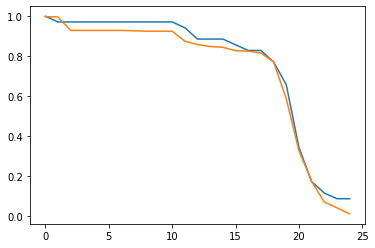

In [18]:
sx = sorted(x,reverse= True)
sf = sorted(f,reverse= True)

detection(sx,sf, step = 25)

In [19]:
avgd = [nx.average_neighbor_degree(g[0][i]) for i in range(len(g[0]))]

In [20]:
avgd_ben = [nx.average_neighbor_degree(g[1][i]) for i in range(len(g[1]))]

In [21]:
avgdList = [list(avgd[i].values()) for i in range(len(avgd))]
avgdListBen = [list(avgd_ben[i].values())for i in range(len(avgd_ben))]

In [22]:
calculateDifference(avgdListBen,avgdList, c, True)

diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


[['Adobe_Reader,Adobe_Reader', 0.9984327592818824, 'Allaple,RAHack,'],
 ['Apple_Software_Update,Apple_Software_Update',
  0.9977586152551877,
  'Bactera,VB,'],
 ['Autoruns,Autoruns', 0.999139465799692, 'ABU,Banload,'],
 ['Battle_for_Wesnoth,Battle_for_Wesnoth',
  0.9983884844486529,
  'Banker,Banker,'],
 ['Chrome,Chrome', 0.9948123683017569, 'Ardamax,Ardamax,'],
 ['Chrome_Setup,Chrome_Setup', 0.9943461794421946, 'Banker,Banker,'],
 ['Copy_to_system_folder,Copy_to_system_folder',
  0.9901126267173768,
  'Bancos,Banker,'],
 ['Firefox,Firefox', 0.9231321998482899, 'Banbra,Banker,'],
 ['Freecell,Freecell', 0.9944038205431037, 'Allaple,RAHack,'],
 ['Freeciv,Freeciv', 0.9769506758220609, 'Banker,Banker,'],
 ['Freeciv_server,Freeciv_server', 0.9959124626338415, 'Bancos,Banker,'],
 ['GIMP,GIMP', 0.9421584922106042, 'Ardamax,Ardamax,'],
 ['Google_Earth,Google_Earth', 0.9526525282975484, 'Banker,Banker,'],
 ['Hello_world,Hello_world', 0.8395149728874816, 'Banker,Banker,'],
 ['Internet_Explorer,I

In [23]:
from networkx.algorithms.link_analysis import pagerank_numpy

In [24]:
pgr = [nx.pagerank_numpy(g[0][i])for i in range(len(g[0]))]
pgr_ben = [nx.pagerank_numpy(g[1][i]) for i in range(len(g[1]))]
pgr_train = [nx.pagerank_numpy(g[2][i]) for i in range(len(g[2]))]

In [25]:
pgrgs = [list(pgr[i].values()) for i in range(len(pgr))]
pgrgs_ben = [list(pgr_ben[i].values())for i in range(len(pgr_ben))]
pgrgs_train = [list(pgr_train[i].values())for i in range(len(pgr_train))]

In [26]:
similarityMetric(calculateDifference(pgrgs,pgrgs_train, c, False))

diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
cA = 336 (0.644914) cB= 410 (0.786948) cC =416 (0.798464)


[0.6449136276391555, 0.7869481765834933, 0.7984644913627639]

In [27]:
srr = sorted(calculateDifference(pgrgs_ben,pgrgs_train,c, True), key= lambda kv:kv[1],reverse= True)
malrr = sorted(calculateDifference(pgrgs,pgrgs_train,c, False), key= lambda kv:kv[1],reverse = True)

diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [28]:
malr = [malrr[i][1] for i in range(len(malrr))]
benr = [srr [i][1] for i in range(len(srr))]

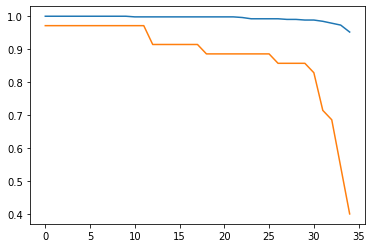

In [29]:
detection(benr,malr,step = 35)

In [30]:
dirs = [createDirs(i) for i in range(1, 6)]

DATASET F1/fold_1/20%_test
DATASET F1/fold_1/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_1\20%_test DATASET F1\fold_1\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_2/20%_test
DATASET F1/fold_2/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_2\20%_test DATASET F1\fold_2\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_3/20%_test
DATASET F1/fold_3/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_3\20%_test DATASET F1\fold_3\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_4/20%_test
DATASET F1/fold_4/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_4\20%_test DATASET F1\fold_4\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_5/20%_test
DATASET F1/fold_5/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_5\20%_test DATASET F1\fold_5\80%_train DATASET F1\specimen_benign\20%_test


In [31]:
graphs = [createGraphs(dirs[i], False) for i in range(len(dirs))]

malware gs |██████████████████████████████████████████████████--------------------------------------------------| 50.6% 

malware gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


train gs |██████████████████████------------------------------------------------------------------------------| 22.7% 

train gs |███████████████████████████████████████████████████████████████-------------------------------------| 63.8% 

train gs |████████████████████████████████████████████████████████████████████████████------------------------| 76.9% 

train gs |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.6% 

train gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
benign gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


malware gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


train gs |███████████████████████████-------------------------------------------------------------------------| 27.3% 

train gs |████████████████████████████████████████------------------------------------------------------------| 40.1% 

train gs |█████████████████████████████████████████████████████-----------------------------------------------| 53.4% 

train gs |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.9% 

train gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
benign gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


malware gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


train gs |█████████████████-----------------------------------------------------------------------------------| 18.0% 

train gs |██████████████████████████████----------------------------------------------------------------------| 30.6% 

train gs |███████████████████████████████████████████---------------------------------------------------------| 43.4% 

train gs |████████████████████████████████████████████████████████--------------------------------------------| 56.3% 

train gs |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.1% 

train gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
benign gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


malware gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


train gs |██████████████████████------------------------------------------------------------------------------| 22.5% 

train gs |████████████████████████████████████████████████████████████████████████████████████----------------| 84.9% 

train gs |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.3% 

train gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
benign gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


malware gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


train gs |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

train gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
benign gs |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [32]:
def pgrank (graphs,fold) :
    mal_g = graphs[0]
    ben_g = graphs[1]
    train_g =  graphs[2]
    
    pgr = [nx.pagerank_numpy(mal_g[i])for i in range(len(mal_g))]
    pgr_ben = [nx.pagerank_numpy(ben_g[i]) for i in range(len(ben_g))]
    pgr_train = [nx.pagerank_numpy(train_g[i]) for i in range(len(train_g))]
    
    pgrgs = [list(pgr[i].values()) for i in range(len(pgr))]
    pgrgs_ben = [list(pgr_ben[i].values())for i in range(len(pgr_ben))]
    pgrgs_train = [list(pgr_train[i].values())for i in range(len(pgr_train))]
    
    srr = sorted(calculateDifference(pgrgs_ben,pgrgs_train, dirs[fold], True), key= lambda kv:kv[1],reverse= True)
    malrr = sorted(calculateDifference(pgrgs,pgrgs_train, dirs[fold], False), key= lambda kv:kv[1],reverse = True)
    print("-------------==========================--------------------")
    malr = [malrr[i][1] for i in range(len(malrr))]
    benr = [srr [i][1] for i in range(len(srr))]
    
    return [malr,benr]

In [33]:
# srr = sorted(calculateDifference(pgrgs_ben,pgrgs_train,c, True), key= lambda kv:kv[1],reverse= True)
# malrr = sorted(calculateDifference(pgrgs,pgrgs_train,c, False), key= lambda kv:kv[1],reverse = True)
# print("-------------==========================--------------------")
# malr = [malrr[i][1] for i in range(len(malrr))]
# benr = [srr [i][1] for i in range(len(srr))]

In [34]:
exps = [pgrank(graphs[i], i ) for i in range(len(graphs))]

diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
-------------==========================--------------------
diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
-------------==========================--------------------
diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
diff calculation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
-------------==========================--------------------
diff calculation: |███████████████████████████

In [35]:
len(exps[i]) for i in range(len(exps))

SyntaxError: invalid syntax (<ipython-input-35-aec7cdc96668>, line 1)